# Setup

In [1]:
import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2 as cv

In [ ]:
## Execute this when running the notebook on google colab
from google.colab import drive
drive.mount('/content/drive')
# Then change this to your own folder path containing the notebook
folder_path = "/content/drive/MyDrive/TREC_Codage"

Mounted at /content/drive


In [2]:
# When running in local
folder_path = ""

# Dataset loading

## Separation and resizing of pictures

In [ ]:
# To load dataset in pickle format
import pickle
file = f'{folder_path}/data_resultsheets/data.pkl'
with open(file, 'rb') as f:
      pict, label = pickle.load(f)
print(pict.shape)
print(label.shape)

(1719, 74, 74)
(1719,)


In [24]:
# Importation and merge of dataset from all the resultsheets
file_name = [f"0{x}" for x in range(1, 10)]
full_da = np.loadtxt(f'{folder_path}data_resultsheets/{file_name[0]}.csv', dtype = "int32", delimiter=',')
for file in file_name[1:]:
    da = np.loadtxt(f'{folder_path}data_resultsheets/{file}.csv', dtype = "int32", delimiter=',')
    full_da = np.append(full_da, da, axis = 0)
file_name_b2 = [f"IMG_000{x}" for x in range(1, 10)]
for file in file_name_b2:
    da = np.loadtxt(f'{folder_path}data_resultsheets/{file}.csv', dtype = "int32", delimiter=',')
    full_da = np.append(full_da, da, axis = 0)
print(full_da.shape)
print(full_da)


(3408, 6233)
[[255 255 255 ... 255 255   1]
 [255 255 255 ... 255 255   1]
 [255 255 255 ... 255 255   1]
 ...
 [255 255 255 ... 255 255   9]
 [255 255 255 ... 255 255   9]
 [255 255 255 ... 255 255   9]]


(3408,)


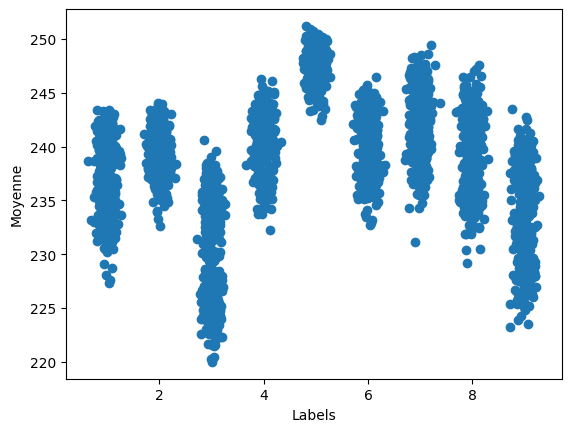

In [25]:
# Plotting mean pixel intensity in function of label.
mean_pix = full_da[:, :-1].mean(axis=1)
print(mean_pix.shape)
labels = full_da[:, -1]
jitter = np.random.normal(0, 0.1, size=len(labels))
plt.plot(labels + jitter, mean_pix, 'o')
plt.xlabel('Labels')
plt.ylabel('Moyenne')
plt.show()
# We can see that for some labels there are two groups of points
# Suggest differences in the two sheets used for annotation
# Maybe due to variation in scanning or writing intensity

In [26]:
# Separation of images and labels
full_da_split = np.split(full_da, [6232], axis = 1)
pict = full_da_split[0]
label = full_da_split[1]
print(pict.shape)
print(label.shape)
# Reshape pict data into matrices corresponding to image size used in extraction
pict = pict.reshape((len(pict), 76, 82))
print(pict.shape)

(3408, 6232)
(3408, 1)
(3408, 76, 82)


In [50]:
# Redimension pictures
new_size = (56, 56)
pict = pict.astype(np.float32)
pict = pict.reshape(-1, pict.shape[1], pict.shape[2], 1)
pict_redim = np.empty((len(pict), 56, 56))
# Boucle sur chaque image de l'array
for i in range(len(pict)):
    img_resized = cv.resize(pict[i], new_size, interpolation=cv.INTER_AREA)
    pict_redim[i] = img_resized
print(pict_redim.shape)

(3408, 56, 56)


## Train-test split

Training DataArray :
(2726, 56, 56)
(2726, 1)
Test DataArray :
(682, 56, 56)
(682, 1)


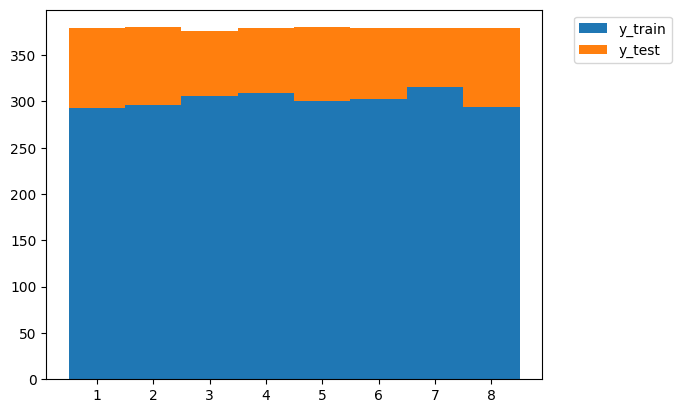

In [51]:
# Split the DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pict_redim, label, test_size=0.2, random_state=42)

# Display the first five rows of the training DataFrame
print("Training DataArray :")
print(X_train.shape)
print(y_train.shape)

# Display the first five rows of the test DataFrame
print("Test DataArray :")
print(X_test.shape)
print(y_test.shape)
plt.hist([y_train.flatten(), y_test.flatten()], bins=np.arange(0.5, 9.5, 1), stacked=True, label=['y_train', 'y_test'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


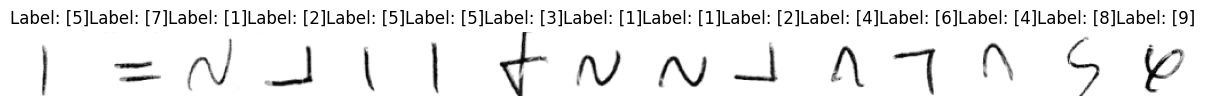

In [52]:
# Define a function to visualize samples from the dataset
def visualize_samples(X, y, num_samples=5):
    # Obtain a subset of random indices
    sample_indices = np.random.choice(len(X), num_samples, replace=False)

    # Create a grid plot for the samples
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))
    for i, idx in enumerate(sample_indices):
        # Reshape and display each sample as an image
        axes[i].imshow(X[idx], cmap='gray')
        # Set the title for each subplot as the corresponding label
        axes[i].set_title(f"Label: {y[idx]}")
        # Hide axis ticks for a cleaner look
        axes[i].axis('off')
    # Adjust layout for better spacing between subplots
    plt.tight_layout()
    # Display the plot
    plt.show()

# Call the function to visualize 10 random samples from the dataset
visualize_samples(pict_redim, label, num_samples=15)



In [53]:
# Get the shape of the first training sample
print(X_train[0].shape)


(56, 56)


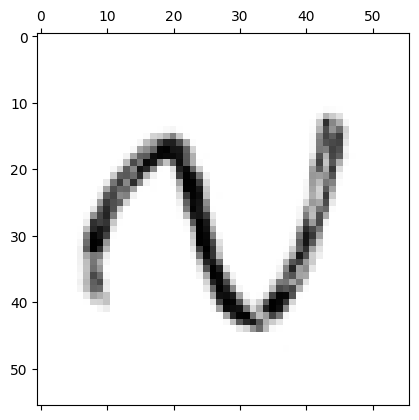

In [54]:
# Visualize the third training sample as an image
plt.matshow(X_train[2], cmap = "gray")
plt.show()  # Display the plot

## Normalisation and creation of picture vectors

In [55]:
# Normalize the pixel values of the images to be between 0 and 1
X_train = X_train / 255
X_test = X_test / 255


In [59]:
print(X_train.shape[1]**2)

3136


In [60]:
# Flatten the 28x28 images into a 784 element vector for each image
X_train_flattened = X_train.reshape(len(X_train), X_train.shape[1]**2)
X_test_flattened = X_test.reshape(len(X_test), X_train.shape[1]**2)
# Check the shape of the flattened training set (should be [num_samples, 784])
print(X_train_flattened.shape)
print(X_test_flattened.shape)

(2726, 3136)
(682, 3136)


# Training of the model

In [63]:
# Define the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(56,56)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train-1, epochs=90, batch_size=64)



Epoch 1/90
43/43 [==============================] - 1s 7ms/step - loss: 2.2687 - accuracy: 0.1574
Epoch 2/90
43/43 [==============================] - 0s 9ms/step - loss: 1.8582 - accuracy: 0.3569
Epoch 3/90
43/43 [==============================] - 0s 9ms/step - loss: 1.6216 - accuracy: 0.4809
Epoch 4/90
43/43 [==============================] - 0s 10ms/step - loss: 1.3230 - accuracy: 0.6009
Epoch 5/90
43/43 [==============================] - 0s 10ms/step - loss: 1.1296 - accuracy: 0.6651
Epoch 6/90
43/43 [==============================] - 0s 10ms/step - loss: 1.0646 - accuracy: 0.6779
Epoch 7/90
43/43 [==============================] - 0s 10ms/step - loss: 0.9630 - accuracy: 0.7073
Epoch 8/90
43/43 [==============================] - 0s 11ms/step - loss: 0.8480 - accuracy: 0.7678
Epoch 9/90
43/43 [==============================] - 0s 11ms/step - loss: 0.7824 - accuracy: 0.7759
Epoch 10/90
43/43 [==============================] - 0s 11ms/step - loss: 0.7951 - accuracy: 0.7630
Epoch 11/90


43/43 [==============================] - 0s 9ms/step - loss: 0.0935 - accuracy: 0.9721
Epoch 84/90
43/43 [==============================] - 0s 11ms/step - loss: 0.2214 - accuracy: 0.9277
Epoch 85/90
43/43 [==============================] - 0s 10ms/step - loss: 0.0672 - accuracy: 0.9824
Epoch 86/90
43/43 [==============================] - 0s 10ms/step - loss: 0.0476 - accuracy: 0.9897
Epoch 87/90
43/43 [==============================] - 0s 8ms/step - loss: 0.0468 - accuracy: 0.9894
Epoch 88/90
43/43 [==============================] - 0s 9ms/step - loss: 0.0367 - accuracy: 0.9912
Epoch 89/90
43/43 [==============================] - 0s 9ms/step - loss: 0.0271 - accuracy: 0.9930
Epoch 90/90
43/43 [==============================] - 0s 8ms/step - loss: 0.0269 - accuracy: 0.9949


# Evaluation of model

In [64]:
# Evaluate the model on the test set
# Subtracting 1 from y_test to align labels if they originally start from 1
test_loss, test_accuracy = model.evaluate(X_test, y_test - 1)
# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

22/22 [==============================] - 0s 2ms/step - loss: 0.3532 - accuracy: 0.9384
Test Loss: 0.35323864221572876
Test Accuracy: 0.9384164214134216


In [65]:
# Generate predictions for the test set
y_predicted = model.predict(X_test)
# Use np.argmax to find the index of the maximum value in the first set of predictions,
# which corresponds to the model's predicted class label for the first image
# Pour détecter les erreur: ajouter une conditions : si
predicted_label = np.argmax(y_predicted[0])
# Convert the model's predictions from probability distributions to class labels
# by finding the index of the max probability for each prediction and adding 1
y_predicted_labels = [np.argmax(i) + 1 for i in y_predicted]

22/22 [==============================] - 0s 2ms/step


Text(95.72222222222221, 0.5, 'Truth')

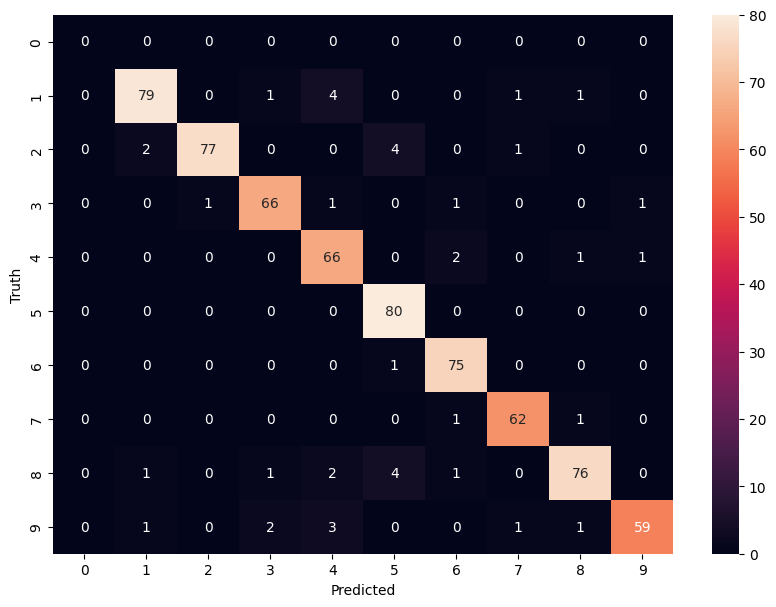

In [66]:
# Generate a confusion matrix to compare the true labels (y_test)
# against the model's predicted labels (y_predicted_labels)
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)
# Set the size of the figure for the heatmap
plt.figure(figsize=(10, 7))

# Create a heatmap to visualize the confusion matrix
# 'annot=True' annotates each cell with the integer value (formatted as 'd' for decimal)
# 'fmt='d'' specifies numeric formatting for annotations
sns.heatmap(cm, annot=True, fmt='d')

# Label the x-axis as "Predicted"
plt.xlabel("Predicted")

# Label the y-axis as "Truth"
plt.ylabel("Truth")

# Save the model

In [67]:
# Save the model to the specified path
model.save("model_CS_largeTrain_Pict56_20240419")

# Evaluate the model on the test dataset to get the loss value & metrics values for the model
test_loss, test_accuracy = model.evaluate(X_test, y_test -1)

# Print out the model's performance on the test dataset
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


INFO:tensorflow:Assets written to: model_CS_largeTrain_Pict56_20240419\assets


INFO:tensorflow:Assets written to: model_CS_largeTrain_Pict56_20240419\assets


22/22 [==============================] - 0s 2ms/step - loss: 0.3532 - accuracy: 0.9384
Test Loss: 0.35323864221572876, Test Accuracy: 0.9384164214134216


# TODO

## Implement checkpoint saving of model

## Try with higher picture size

## Make custom metric